<ipython-input-1-5703d682929b>:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  weighted_entropy = np.sum(


Decision Tree Rules:
IF overlap_penggunaan_sosial = OPS0 AND overlap_hunian = OHU0 AND overlap_usaha = OU0 AND contain_usaha = CU0 AND overlap_sungai_75m = SC0 AND contain_penggunaan_sosial = CPS0 AND overlap_penggunaan_lain = OPL0 THEN Class 3
IF overlap_penggunaan_sosial = OPS0 AND overlap_hunian = OHU0 AND overlap_usaha = OU0 AND contain_usaha = CU0 AND overlap_sungai_75m = SC0 AND contain_penggunaan_sosial = CPS0 AND overlap_penggunaan_lain = OPL1 THEN Class 1
IF overlap_penggunaan_sosial = OPS0 AND overlap_hunian = OHU0 AND overlap_usaha = OU0 AND contain_usaha = CU0 AND overlap_sungai_75m = SC0 AND contain_penggunaan_sosial = CPS1 AND overlap_penggunaan_lain = OPL0 THEN Class 3
IF overlap_penggunaan_sosial = OPS0 AND overlap_hunian = OHU0 AND overlap_usaha = OU0 AND contain_usaha = CU0 AND overlap_sungai_75m = SC0 AND contain_penggunaan_sosial = CPS1 AND overlap_penggunaan_lain = OPL1 THEN Class 3
IF overlap_penggunaan_sosial = OPS0 AND overlap_hunian = OHU0 AND overlap_usaha = O

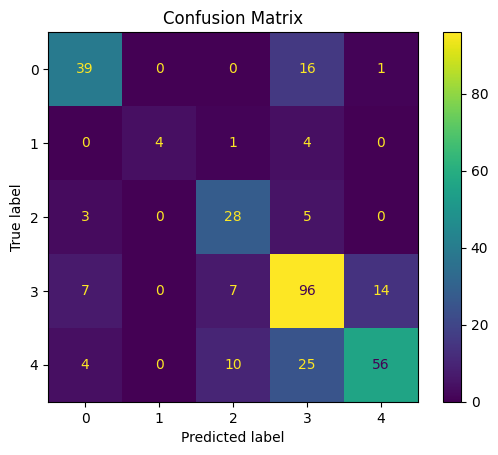

In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from graphviz import Digraph

class C45:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        unique_classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def information_gain(self, X, y, feature):
        original_entropy = self.entropy(y)
        values, counts = np.unique(X[:, feature], return_counts=True)
        weighted_entropy = np.sum(
            (counts[i] / np.sum(counts)) * self.entropy(y[X[:, feature] == values[i]])
            for i in range(len(values))
        )
        return original_entropy - weighted_entropy

    def split_information(self, X, feature):
        values, counts = np.unique(X[:, feature], return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def gain_ratio(self, X, y, feature):
        gain = self.information_gain(X, y, feature)
        split_info = self.split_information(X, feature)
        return gain / split_info if split_info != 0 else 0

    def best_feature(self, X, y):
        gain_ratios = [self.gain_ratio(X, y, feature) for feature in range(X.shape[1])]
        return np.argmax(gain_ratios)

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return y[0]
        if len(y) < self.min_samples_split or (self.max_depth and depth >= self.max_depth):
            return np.bincount(y).argmax()

        best_feature = self.best_feature(X, y)
        tree = {best_feature: {}}
        for value in np.unique(X[:, best_feature]):
            sub_X = X[X[:, best_feature] == value]
            sub_y = y[X[:, best_feature] == value]
            tree[best_feature][value] = self.build_tree(sub_X, sub_y, depth + 1)
        return tree

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_sample(self, tree, sample):
        if not isinstance(tree, dict):
            return tree
        feature = list(tree.keys())[0]
        value = sample[feature]
        subtree = tree[feature].get(value)
        if subtree is None:
            return np.bincount(y).argmax()  # Voting mechanism for missing value
        return self.predict_sample(subtree, sample)

    def predict(self, X):
        return np.array([self.predict_sample(self.tree, sample) for sample in X])

    def plot_tree(self, tree=None, dot=None, parent=None, edge_label=""):
        if tree is None:
            tree = self.tree
        if dot is None:
            dot = Digraph()
            dot.node(name="root", label=f"Feature {list(tree.keys())[0]}")
            parent = "root"

        if not isinstance(tree, dict):
            dot.node(name=str(id(tree)), label=str(tree), shape='ellipse')
            dot.edge(parent, str(id(tree)), label=edge_label)
            return dot

        feature = list(tree.keys())[0]
        for value, subtree in tree[feature].items():
            node_name = str(id(subtree))
            dot.node(name=node_name, label=f"Feature {feature} = {value}" if isinstance(subtree, dict) else str(subtree))
            dot.edge(parent, node_name, label=edge_label)
            self.plot_tree(subtree, dot=dot, parent=node_name, edge_label=str(value))
        return dot

    def print_rules(self, tree=None, feature_names=None, path=[]):
        if tree is None:
            tree = self.tree
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(len(tree))]

        if not isinstance(tree, dict):
            print("IF " + " AND ".join(path) + f" THEN Class {tree}")
            return

        feature_index = list(tree.keys())[0]
        for value, subtree in tree[feature_index].items():
            condition = f"{feature_names[feature_index]} = {value}"
            self.print_rules(subtree, feature_names, path + [condition])

data = pd.read_csv('/content/Data_Banjir_Jakbar.csv')

X = data[['contain_hunian', 'overlap_hunian', 'contain_usaha', 'overlap_usaha',
          'contain_penggunaan_sosial', 'overlap_penggunaan_sosial',
          'contain_kegiatan_keagamaan', 'overlap_kegiatan_keagamaan',
          'contain_penggunaan_lain', 'overlap_penggunaan_lain',
          'overlap_sungai_25m', 'overlap_sungai_50m',
          'overlap_sungai_75m', 'overlap_sungai_100m',
          'overlap_sungai_>100m']].values

y = data['Kategori'].astype('category').cat.codes.values

c45 = C45(max_depth=7)
c45.fit(X, y)

# Print the rules of the decision tree
feature_names = ['contain_hunian', 'overlap_hunian', 'contain_usaha', 'overlap_usaha',
                 'contain_penggunaan_sosial', 'overlap_penggunaan_sosial',
                 'contain_kegiatan_keagamaan', 'overlap_kegiatan_keagamaan',
                 'contain_penggunaan_lain', 'overlap_penggunaan_lain',
                 'overlap_sungai_25m', 'overlap_sungai_50m',
                 'overlap_sungai_75m', 'overlap_sungai_100m',
                 'overlap_sungai_>100m']

print("Decision Tree Rules:")
c45.print_rules(feature_names=feature_names)

predictions = c45.predict(X)
print("Predictions:", predictions)

accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions, average='macro')
recall = recall_score(y, predictions, average='macro')
f1 = f1_score(y, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

conf_matrix = confusion_matrix(y, predictions)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

In [2]:
tree_plot = c45.plot_tree()
tree_plot.render("c45_decision_tree", format="png", view=True)

'c45_decision_tree.png'

In [3]:
data['Predictions'] = predictions

output_file = '/content/Data_Banjir_Jakbar_with_predictions.csv'
data.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

Predictions saved to /content/Data_Banjir_Jakbar_with_predictions.csv
